## BoilerPlate command

It’s standard practice to start the notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 64. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 64 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from fastai.vision import *
from alexnet import *
bs=128

## Downloading Dataset

To download Cats vs dog data you can use Kaggle CLI -

In [17]:
#!kaggle competitions download -c dogs-vs-cats

By running the above command, the data is downloaded and stored in the path shown above. Let's look at how the data directory is set up as we have to import data from these directories. Let's start by looking at path directory, and we can see below that our data already have training and testing folder.

In [3]:
path = Path('../data/cats_dog/')

## Importing Data

In [4]:
fnames = get_image_files(path)

In [5]:
data = ImageDataBunch.from_name_re(path, fnames, 
                                   pat=r'([^/]+)\.\d+.jpg$', 
                                   ds_tfms=get_transforms(), 
                                   valid_pct=0.2,
                                   size=227, 
                                   bs=bs
                                  ).normalize()

In [6]:
data.train_ds

LabelList
y: CategoryList (20000 items)
[Category cat, Category dog, Category cat, Category cat, Category cat]...
Path: ../data/cats_dog
x: ImageItemList (20000 items)
[Image (3, 374, 500), Image (3, 500, 422), Image (3, 245, 499), Image (3, 322, 315), Image (3, 374, 500)]...
Path: ../data/cats_dog

In [7]:
data.valid_ds

LabelList
y: CategoryList (5000 items)
[Category dog, Category dog, Category dog, Category cat, Category dog]...
Path: ../data/cats_dog
x: ImageItemList (5000 items)
[Image (3, 499, 367), Image (3, 370, 449), Image (3, 375, 499), Image (3, 349, 339), Image (3, 344, 384)]...
Path: ../data/cats_dog

['cat', 'dog']
2


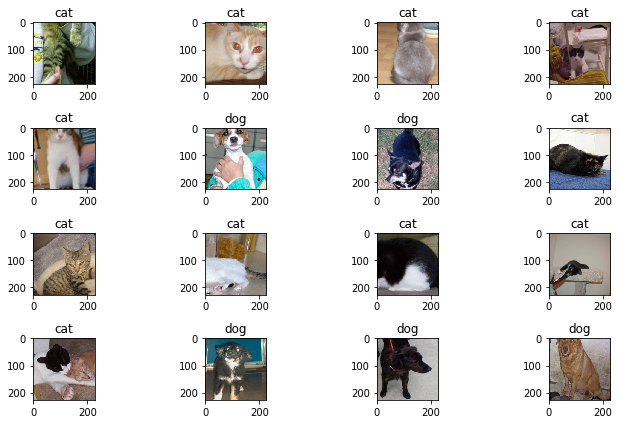

In [8]:
print(data.classes) ## Prints class labels
print(data.c) ## Prints number of classes
data.show_batch(rows=4, figsize=(10,6), hide_axis=False) ## Show sample data

## About the model

Minivggnet is just a smaller version of VGG family of model which contains all the key elements to build an actual VGG model. It's just miniature version which can do reasonably well without requiring a lot of compute time. The model is having following architecture -

((CONV=>ACT=>BN)x2 =>POOL=>DO)x2=>FC=>ACT=>DO=>FC=>SOFTMAX

Glossary-
- CONV -> Convolution with kernel size 3x3 with same padding
- ACT -> ReLU Activation
- BN -> Batch Normalization
- DO -> Dropout
- Pool -> Max pooling with size 2x2
- FC -> Fully connected layer

## Training the model

We have defined our shallownet model in shallownet.py file, now we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [9]:
## Defining the learner
alexnet_learner = Learner(data=data, 
                          model=ALEXNet(n_class=data.c), 
                          loss_func=nn.CrossEntropyLoss(),
                          metrics=accuracy)

In [10]:
alexnet_learner.model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU()
    (2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Dropout(p=0.25)
    (5): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU()
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Dropout(p=0.25)
    (10): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU()
    (15): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (16): Co

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


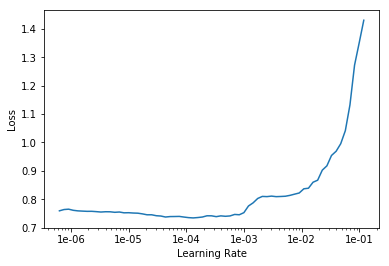

In [11]:
## Finidng Ideal learning late
alexnet_learner.lr_find()
alexnet_learner.recorder.plot()

In [12]:
alexnet_learner.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.638005,0.766830,0.655800
2,0.534617,0.494307,0.768000
3,0.477765,0.535594,0.730800
4,0.398305,0.414883,0.796400
5,0.344727,0.398703,0.838800
6,0.293345,0.304188,0.878400
7,0.242300,0.204189,0.916600
8,0.212505,0.194056,0.923600
9,0.173101,0.159934,0.937600
10,0.160533,0.157122,0.937600


In [13]:
alexnet_learner.save('alexnet_stage-1')

In [14]:
from sklearn.metrics import classification_report
interp = ClassificationInterpretation.from_learner(alexnet_learner)
print(classification_report(interp.y_true,interp.pred_class))

              precision    recall  f1-score   support

           0       0.94      0.93      0.94      2469
           1       0.94      0.94      0.94      2531

   micro avg       0.94      0.94      0.94      5000
   macro avg       0.94      0.94      0.94      5000
weighted avg       0.94      0.94      0.94      5000



As we can see we are reaching 94% accuracy just by using AlexNet as compared to 50% if we have picked classes at random. 

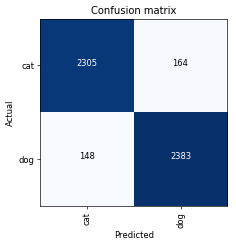

In [18]:
interp.plot_confusion_matrix(figsize=(4,4), dpi=60)

Let's see where our model is getting tricked.

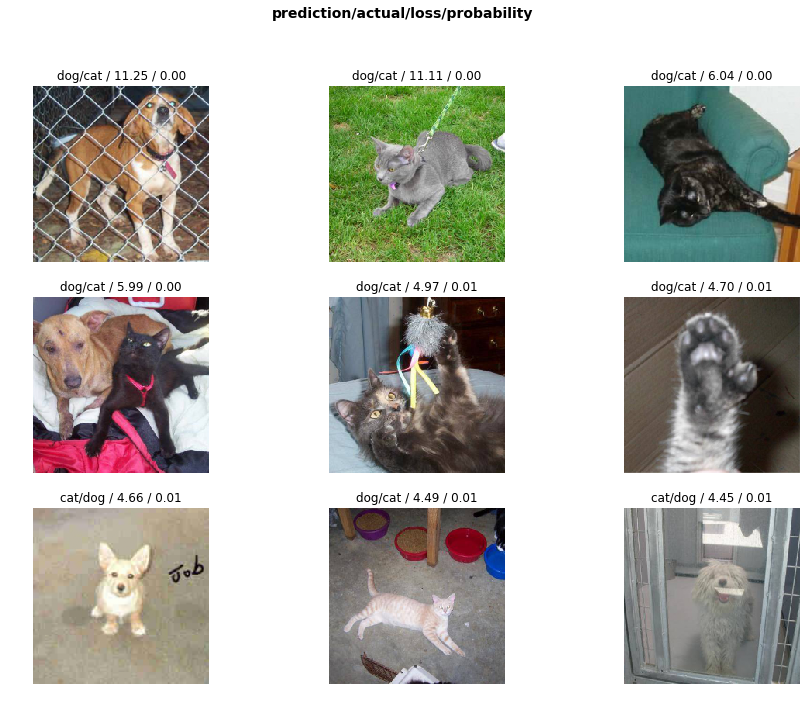

In [19]:
interp.plot_top_losses(9, figsize=(15,11))